In [1]:
# Import necessary libraries
import os
import shutil
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, f1_score
from pathlib import Path
import random
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Import necessary tools
import tensorflow as tf
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

2024-05-19 07:37:12.303889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 07:37:12.304009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 07:37:12.481602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU available (YESSSS!!!!!)


In [3]:
# Configuration settings
class Config:
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_epochs = 50
    num_classes = 3
    learning_rate = 1e-4
    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
    lr_decay = 0.1
    patience = 5
    batch_size = 32
    criterion = nn.CrossEntropyLoss()

config = Config()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s] 


In [4]:
# Label mapping for the dataset
label_mapping = {0: 0, 1: 1, 2: 1, 3: 2, 4: 2}
dataset_path = "/kaggle/input/knee-osteoarthritis-dataset-with-severity/"

In [5]:
# Function to load and preprocess data
def load_data(label_paths, label_map):
    image_paths = []
    labels = []
    for label in label_paths:
        img_list = os.listdir(f"{dataset_path}{label_paths[label]}")
        image_paths += [f"{dataset_path}{label_paths[label]}/" + p for p in img_list]
        labels += [label_map[label]] * len(img_list)
    return pd.DataFrame({"Filepath": image_paths, "Labels": labels})

In [6]:
# Load training and validation data
train_data = load_data({0: 'train/0', 2: 'train/2', 3: 'train/3', 4: 'train/4'}, label_mapping)
val_data = load_data({0: 'val/0', 2: 'val/2', 3: 'val/3', 4: 'val/4'}, label_mapping)


In [7]:
# Custom dataset class
class KneeOADataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Data transformations
pre_processing = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256, 256)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomResizedCrop((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'eval': transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [9]:
# Create data loaders
train_loader = DataLoader(KneeOADataset(train_data, transform=pre_processing['train']), batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(KneeOADataset(val_data, transform=pre_processing['eval']), batch_size=config.batch_size)

In [10]:
def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    return total_loss / len(train_loader.dataset)


In [11]:
# Model setup
model = config.model
model.fc = nn.Linear(model.fc.in_features, config.num_classes)
criterion = config.criterion
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config.patience, factor=config.lr_decay, verbose=True)
device = config.device
model = model.to(device)
best_model_params_path = os.path.join('/kaggle/working/', 'best_model_params.pt')


In [12]:
from sklearn.metrics import confusion_matrix


In [28]:
def validate_model(model, val_loader, criterion, device):
  """
  Evaluates the model on the validation dataset and returns performance metrics.

  Args:
      model (torch.nn.Module): The model to be evaluated.
      val_loader (torch.utils.data.DataLoader): The validation data loader.
      criterion (torch.nn.Module): The loss function.
      device (str): The device to use for computations ('cpu' or 'cuda').

  Returns:
      tuple: A tuple containing validation loss, accuracy, F1 score, validation losses (list), 
              and the confusion matrix.
  """
  model.eval()
  total_loss = 0
  preds, true_labels = [], []
  val_losses = []  # Initialize list to store validation losses

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      total_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs.data, 1)
      preds.extend(predicted.cpu().numpy())
      true_labels.extend(labels.cpu().numpy())
      val_losses.append(loss.item() / len(inputs))  # Track loss per batch

  accuracy = accuracy_score(true_labels, preds)
  f1 = f1_score(true_labels, preds, average='weighted')
  cm = confusion_matrix(true_labels, preds)  # Calculate confusion matrix

  return total_loss / len(val_loader.dataset), accuracy, f1, val_losses, cm


In [29]:
 # pip install pytorch-lightning

In [30]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [31]:
# Early Stopping callback configuration
early_stop_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    min_delta=0.001,  # Minimum improvement threshold
    patience=3,  # Stop training after 5 epochs without improvement
    verbose=True,  # Print information at each validation check
    mode='min'  # Track minimum validation loss
)

In [58]:
def train_loop(epochs, model, train_loader, val_loader, optimizer, criterion, scheduler, device):
  best_acc = 0
  early_stop_count = 0
  patience = 5
  train_losses = []
  val_accuracies = []
  val_losses = []  # Initialize val_losses list here

  for epoch in range(epochs):
    print(f'Epoch {epoch + 1}/{epochs}')

    # Train model
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Validate model
    val_loss, val_acc, val_f1, val_losses_, val_cm = validate_model(model, val_loader, criterion, device)  # Get losses from validation

    val_losses.extend(val_losses_)  # Accumulate validation losses from batches
    val_accuracies.append(val_acc)

    # Early Stopping Logic
    if val_acc > best_acc:
      best_acc = val_acc
      torch.save(model.state_dict(), best_model_params_path)
      print('Model improved and saved')
      early_stop_count = 0
    else:
      early_stop_count += 1

    # Stop training if validation accuracy doesn't improve for 'patience' epochs
    if early_stop_count >= patience:
      print(f'Early stopping triggered after {patience} epochs without improvement')
      break

    scheduler.step(val_loss)
    print(f"Epoch {epoch + 1} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}, Val F1: {val_f1:.4f}")

  return train_losses, val_accuracies  # Return training and validation metrics for plotting


In [59]:
train_loop(config.num_epochs, model, train_loader, val_loader, optimizer, criterion, scheduler, device)

Epoch 1/50


100%|██████████| 148/148 [01:29<00:00,  1.65it/s]


Model improved and saved
Epoch 1 - Train loss: 0.6620, Val loss: 0.6168, Val accuracy: 0.7325, Val F1: 0.7194
Epoch 2/50


100%|██████████| 148/148 [00:55<00:00,  2.66it/s]


Epoch 2 - Train loss: 0.6596, Val loss: 0.6333, Val accuracy: 0.7281, Val F1: 0.7112
Epoch 3/50


100%|██████████| 148/148 [00:54<00:00,  2.69it/s]


Model improved and saved
Epoch 3 - Train loss: 0.6296, Val loss: 0.6062, Val accuracy: 0.7385, Val F1: 0.7258
Epoch 4/50


100%|██████████| 148/148 [00:55<00:00,  2.66it/s]


Model improved and saved
Epoch 4 - Train loss: 0.6250, Val loss: 0.6324, Val accuracy: 0.7429, Val F1: 0.7497
Epoch 5/50


100%|██████████| 148/148 [00:55<00:00,  2.66it/s]


Model improved and saved
Epoch 5 - Train loss: 0.6117, Val loss: 0.4887, Val accuracy: 0.7949, Val F1: 0.7950
Epoch 6/50


100%|██████████| 148/148 [00:55<00:00,  2.65it/s]


Epoch 6 - Train loss: 0.6101, Val loss: 0.5785, Val accuracy: 0.7727, Val F1: 0.7740
Epoch 7/50


100%|██████████| 148/148 [00:55<00:00,  2.67it/s]


Epoch 7 - Train loss: 0.6021, Val loss: 0.5355, Val accuracy: 0.7652, Val F1: 0.7576
Epoch 8/50


100%|██████████| 148/148 [00:55<00:00,  2.65it/s]


Epoch 8 - Train loss: 0.6035, Val loss: 0.5195, Val accuracy: 0.7667, Val F1: 0.7696
Epoch 9/50


100%|██████████| 148/148 [00:56<00:00,  2.64it/s]


Model improved and saved
Epoch 9 - Train loss: 0.5857, Val loss: 0.4874, Val accuracy: 0.8068, Val F1: 0.8045
Epoch 10/50


100%|██████████| 148/148 [00:57<00:00,  2.60it/s]


Epoch 10 - Train loss: 0.6006, Val loss: 0.4872, Val accuracy: 0.8068, Val F1: 0.8007
Epoch 11/50


100%|██████████| 148/148 [00:55<00:00,  2.65it/s]


Epoch 11 - Train loss: 0.5744, Val loss: 0.4811, Val accuracy: 0.7994, Val F1: 0.7974
Epoch 12/50


100%|██████████| 148/148 [00:54<00:00,  2.69it/s]


Epoch 12 - Train loss: 0.5599, Val loss: 0.6778, Val accuracy: 0.7459, Val F1: 0.7261
Epoch 13/50


100%|██████████| 148/148 [00:55<00:00,  2.66it/s]


Epoch 13 - Train loss: 0.5901, Val loss: 0.4970, Val accuracy: 0.7994, Val F1: 0.7945
Epoch 14/50


100%|██████████| 148/148 [00:55<00:00,  2.66it/s]


Early stopping triggered after 5 epochs without improvement


([0.6620005719357391,
  0.659648401043925,
  0.6295535210724715,
  0.6250455378226476,
  0.6116856085175896,
  0.6100606703193936,
  0.6021484404122134,
  0.6035077456992658,
  0.5856557491968369,
  0.6006463987789009,
  0.5744465525031393,
  0.5598711658360489,
  0.5900628759210027,
  0.5611413573170756],
 [0.7325408618127786,
  0.7280832095096582,
  0.7384843982169391,
  0.7429420505200595,
  0.7949479940564635,
  0.7726597325408618,
  0.7652303120356612,
  0.7667161961367014,
  0.8068350668647846,
  0.8068350668647846,
  0.799405646359584,
  0.7459138187221397,
  0.799405646359584,
  0.7904903417533432])

In [60]:
# Test data loading
test_data = load_data({0: 'test/0', 2: 'test/2', 3: 'test/3', 4: 'test/4'}, label_mapping)
test_loader = DataLoader(KneeOADataset(test_data, transform=pre_processing['eval']), batch_size=config.batch_size)

In [61]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load(best_model_params_path))
test_loss, test_acc, test_f1, val_losses, _ = validate_model(model, test_loader, criterion, device)
print(f'Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')


Test accuracy: 0.8103, Test F1: 0.8050


In [62]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)  # Save model state dictionary

# After training loop
save_model(model, "/kaggle/working/saved_model.pt")  # Replace "saved_model.pt" with your desired path

In [63]:
# Model setup
model = config.model
model.fc = nn.Linear(model.fc.in_features, config.num_classes)
criterion = config.criterion
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=config.patience, factor=config.lr_decay, verbose=True)
device = config.device
model = model.to(device)
best_model_params_path = os.path.join('/kaggle/working/', 'best_model_params.pt')


In [64]:
# Replace "saved_model.pt" with your actual saved model path
model_path = "/kaggle/working/saved_model.pt"
model = config.model  # Assuming you have the model class defined in your `Config` class

# Use 'eval' transformation for consistency with training preprocessing
transform = pre_processing['eval']

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
# Ensure you have already loaded the test data using `test_data` and `test_loader`
#test_loss, test_acc, test_f1, test_losses, test_true_labels, test_preds, test_cm = validate_model(model, test_loader, config.criterion, config.device)
test_loss, test_acc, test_f1, test_losses, test_cm = validate_model(model, test_loader, config.criterion, config.device)

print(f'Test accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}')

Test accuracy: 0.8103, Test F1: 0.8050


In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, labels, title, normalize=False):
  """
  Plots the confusion matrix with or without normalization.

  Args:
      cm: Confusion matrix (2D array).
      labels: List of class labels.
      title: Title for the plot.
      normalize: Boolean flag indicating normalization (True) or raw counts (False).
  """
  plt.figure(figsize=(8, 6))

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    cmap = 'YlOrBr'  # Choose colormap for normalized values
  else:
    cmap = 'viridis'  # Choose colormap for raw counts

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center", fontsize=12, color="black" if cm[i, j] > 0.5 else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()

In [67]:
# Grade labels (assuming 3 classes based on test_cm dimensions)
grade_labels = ["Healthy", "Moderate", "Severe"]

# Calculate overall accuracy
accuracy = (np.trace(test_cm) / test_cm.sum()) * 100


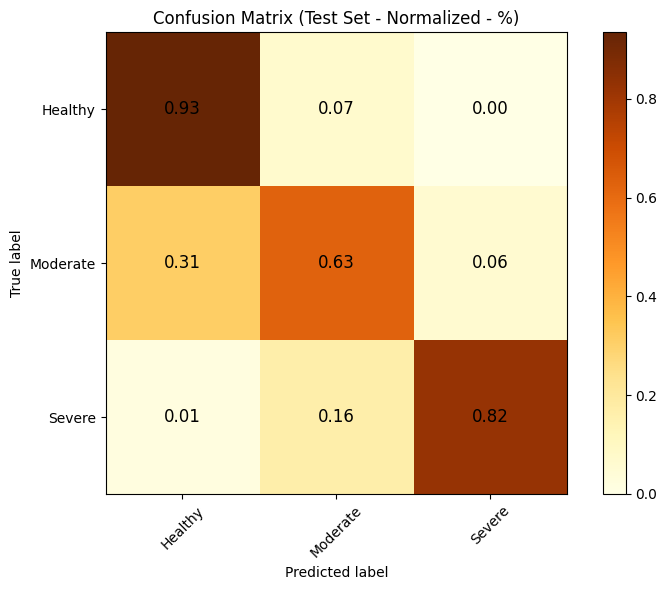

In [68]:
import matplotlib.pyplot as plt
import itertools
# Plot heatmap with normalization (showing proportions)
plot_confusion_matrix(test_cm.copy(), grade_labels.copy(), "Confusion Matrix (Test Set - Normalized - %)", normalize=True)

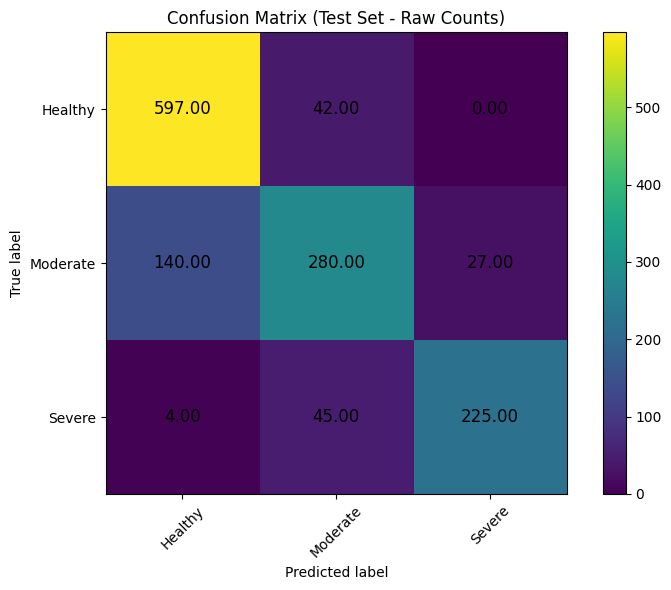

In [69]:

# Plot heatmap without normalization (showing raw counts)
plot_confusion_matrix(test_cm.copy(), grade_labels.copy(), "Confusion Matrix (Test Set - Raw Counts)", normalize=False)


In [70]:
# Print the confusion matrix
print("Confusion Matrix:\n", test_cm)

# Print the overall accuracy
print("Overall Accuracy:", accuracy, "%")

# Interpretation (example)
print("\nInterpretation:")
print("The model correctly classified", test_cm[0][0], "out of", test_cm[0].sum(), "Grade 0 (Healthy) knee images.")

Confusion Matrix:
 [[597  42   0]
 [140 280  27]
 [  4  45 225]]
Overall Accuracy: 81.02941176470588 %

Interpretation:
The model correctly classified 597 out of 639 Grade 0 (Healthy) knee images.
